## Imports

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import string
import contractions
from tqdm import tqdm
tqdm.pandas(desc="Progress Bar")

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords       # used for preprocessing
from nltk.stem import WordNetLemmatizer # used for preprocessing
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')

# from deep_translator import GoogleTranslator
from langdetect import DetectorFactory, detect
DetectorFactory.seed = 0

import warnings
warnings.filterwarnings('ignore')

In [52]:
# dataset link: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification

ROOT_DIR = Path().resolve().parent

TRAIN_DATA_PATH = ROOT_DIR/"input/WELFake_Dataset.csv"
# TEST_DATA_PATH = ROOT_DIR/"input/test.csv"

## Get Data

Dataset Description

A full training dataset with the following attributes:

- `title`: the title of a news article
- `text`: the text of the article; could be incomplete
- `label`: a label that marks the article as potentially unreliable
    - 1: real
    - 0: fake

In [3]:
data = pd.read_csv(TRAIN_DATA_PATH, usecols=['title', 'text', 'label'])
data.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [4]:
data.shape

(72134, 3)

In [5]:
# random sample

import random

random_idx = random.sample(data.index.to_list(), 1)[0]
random_news = data.iloc[random_idx]['text']

print(random_news[:len(random_news)//2])

In a YouTube video posted on January 19, CloudGate Studio demonstrated an experiment in   virtual reality tracking with the HTC Vive. [With two controllers in his hands, and two more strapped to his feet, CloudGate CEO Steve Bowler demonstrated some amazing live tracking of his body in a  3D VR environment, using two of Valve’s HTC Vives. He posted a link to the video on Twitter:  Wake up, Neo. @CloudGateStudio just figured out how to give you a   presence in VR. pic. twitter.   —   Steve Bowler (@gameism) January 19, 2017,  Bowler first showed off the function of virtual hands in the game, but said that it’s something “everyone’s [doing]. ” Then he displayed unfinished virtual arms, saying “we’re not going to ship this yet,” but “it’s getting there. ” But CloudGate wanted to “do more than just this   …     like, a lot more. ” So with the aid of four total motion controllers in addition to an HTC Vive headset, Bowler showed what he called “a pretty good facsimile of a human body in VR.

In [6]:
data.isna().sum()

title    558
text      39
label      0
dtype: int64

In [7]:
data[data.text==' '].shape, data[data.title==' '].shape

((738, 3), (0, 3))

## Language Detection in Text

In [8]:
def detect_lang(row):
    """
    Detects different languages in the dataset.
    """
    try:
        text = ''
        if pd.isnull(row['title']):
            text = row['text']
        elif pd.isnull(row['text']) or row['text'] == ' ':
            text = row['title']
        else:
            text =  " ".join([row['title'], row['text']])

        return detect(text)
    except:
        return 'None'

In [9]:
data['language'] = data.progress_apply(detect_lang, axis=1)

Progress Bar: 100%|██████████████████████████████████████████████████████████████| 72134/72134 [12:55<00:00, 93.04it/s]


In [10]:
data.language.value_counts()

language
en       71540
ru         156
es         141
de         130
fr          72
ar          19
None        10
pt           9
it           8
tr           7
id           5
so           4
hr           4
nl           4
no           3
ro           3
pl           2
tl           2
da           2
el           2
cy           2
ca           1
hu           1
sv           1
et           1
zh-cn        1
sw           1
vi           1
fi           1
lt           1
Name: count, dtype: int64

In [11]:
# Only considering English language
data = data[data.language=='en']
data.shape

(71540, 4)

## Train-Test Split

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_df, test_df = train_test_split(data, test_size=0.1, random_state=42)

In [16]:
train_df.shape, test_df.shape

((64386, 4), (7154, 4))

In [19]:
train_df = train_df.reset_index(drop=True).drop(['language'], axis=1)

test_df = test_df.reset_index(drop=True).drop(['language'], axis=1)

In [20]:
train_df.to_csv("../input/WELFake_Train_Dataset.csv", index=False)

test_df.to_csv("../input/WELFake_Test_Dataset.csv", index=False)

## Load train-test data

In [2]:
# Load the train test data
train_df = pd.read_csv("../input/WELFake_Train_Dataset.csv")
test_df = pd.read_csv("../input/WELFake_Test_Dataset.csv")

train_df.head()

,title,text,label
0,Syrian Kurdish YPG accuses Turkey of Afrin agg...,BEIRUT (Reuters) - A Syrian Kurdish militia ac...,0
1,GOP has a day of reckoning coming,License DMCA The face of the Republican Party....,1
2,Antiquities destroyed at Palmyra by the Islami...,"A general view taken on March 27, 2016, shows ...",0
3,Trump will win November 8 election: American p...,Politics US Republican presidential nominee Do...,1
4,DUP leader spoke to PM May on Brexit border,BELFAST (Reuters) - The head of the Northern I...,0


## Text Data Statistics

- We have Balanced dataset with almost equal number of `1: unreliable, 0: reliable` news labels.
- We only need `title`, `text` and `label` columns
- 99% of the news articles have less than equal to 4095 words in them
- 99% of the title have less than equal to 23 words in them
- `title` and `text` column has few null values, which will be dropped

In [4]:
# We have Balanced dataset
train_df.label.value_counts()

label
1    32869
0    31517
Name: count, dtype: int64

In [5]:
# null values
train_df.isna().sum()

title    464
text       1
label      0
dtype: int64

In [6]:
train_df[train_df.text==' '].shape

(610, 3)

In [7]:
# Statistics of news 'text' in the data
train_df["text"].str.split().str.len().describe(percentiles=[0.05, 0.75, 0.95, 0.99])

# 99% of the news articles have less than equal to 2777 words in them

count    64385.000000
mean       542.413171
std        630.219627
min          0.000000
5%          48.000000
50%        399.000000
75%        667.000000
95%       1418.800000
99%       2777.320000
max      24234.000000
Name: text, dtype: float64

In [8]:
# Statistics of news 'title' in the data
train_df["title"].str.split().str.len().describe(percentiles=[0.05, 0.75, 0.95, 0.99])

# 99% of the title have less than equal to 26 words in them

count    63922.000000
mean        12.286912
std          4.129125
min          1.000000
5%           7.000000
50%         12.000000
75%         15.000000
95%         20.000000
99%         26.000000
max         72.000000
Name: title, dtype: float64

## Data Cleaning

In [3]:
stop_word = stopwords.words('english')
le = WordNetLemmatizer()

def text_cleaning(text:str) -> str:
    if pd.isnull(text) or text == '' or text.isspace():
        return "?"
    
    # lower-case everything
    text = text.lower().strip()
    
    # expand all the short-form words
    text = contractions.fix(text)
    
    # For removing puctuations
    translator = str.maketrans('', '', string.punctuation)
    
    # remove any special chars
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) # Remove URLs
    text = re.sub(r'\S+@\S+', '', text) # Remove emails
    text = re.sub(r'\b\d{1,3}[-./]?\d{1,3}[-./]?\d{1,4}\b', '', text) # Remove phone numbers
    text = text.translate(translator) # Remove puctuations
    text = re.sub(r'[^a-zA-Z]', ' ', text) # Remove other non-alphanumeric characters 
    
    # tokenization
    word_tokens = word_tokenize(text)
    
    # remove stop-word and lemmatize
    tokens = [le.lemmatize(w) for w in word_tokens if w not in stop_word] #  and len(w)>3
    
    cleaned_text = " ".join(tokens)
    
    if cleaned_text.isspace() or cleaned_text=='':
        return "?"
    return cleaned_text

In [10]:
# cols_to_remove = ['id','author']
text_features = ['title', 'text']
target_col = ['label']


def make_news_feature(row):
    try:
        news = ''
        if row['title']=='?':
            news = row['text']
        elif row['text']=='?':
            news = row['title']
        else:
            news = " ".join([row['title'], row['text']])
        
        return news
    except:
        return 'None'


def clean_data(df:pd.DataFrame)->pd.DataFrame:        
    df['title'] = df['title'].progress_apply(lambda x: text_cleaning(x))
    df['text'] = df['text'].progress_apply(lambda x: text_cleaning(x))
    
    df['news'] = df.progress_apply(make_news_feature, axis=1) 
    return df[['news', 'label']]
    return df

In [11]:
cleaned_train_df = clean_data(train_df)

Progress Bar: 100%|███████████████████████████████████████████████████████████| 64386/64386 [00:00<00:00, 67630.23it/s]


In [16]:
cleaned_train_df.to_csv("../input/CLEANED_WELFake_Train_Dataset.csv", index=False)

In [17]:
cleaned_test_df = clean_data(test_df)

cleaned_test_df.to_csv("../input/CLEANED_WELFake_Test_Dataset.csv", index=False)

Progress Bar: 100%|█████████████████████████████████████████████████████████████| 7154/7154 [00:00<00:00, 78250.80it/s]


In [18]:
cleaned_train_df.head()

,news,label
0,syrian kurdish ypg accuses turkey afrin aggres...,0
1,gop day reckoning coming license dmca face rep...,1
2,antiquity destroyed palmyra islamic state gene...,0
3,trump win november election american professor...,1
4,dup leader spoke pm may brexit border belfast ...,0


## EDA

In [20]:
clean_train_df = pd.read_csv("../input/CLEANED_WELFake_Train_Dataset.csv")
clean_train_df.head()

,news,label
0,syrian kurdish ypg accuses turkey afrin aggres...,0
1,gop day reckoning coming license dmca face rep...,1
2,antiquity destroyed palmyra islamic state gene...,0
3,trump win november election american professor...,1
4,dup leader spoke pm may brexit border belfast ...,0


### Word cloud for all words in the dataset

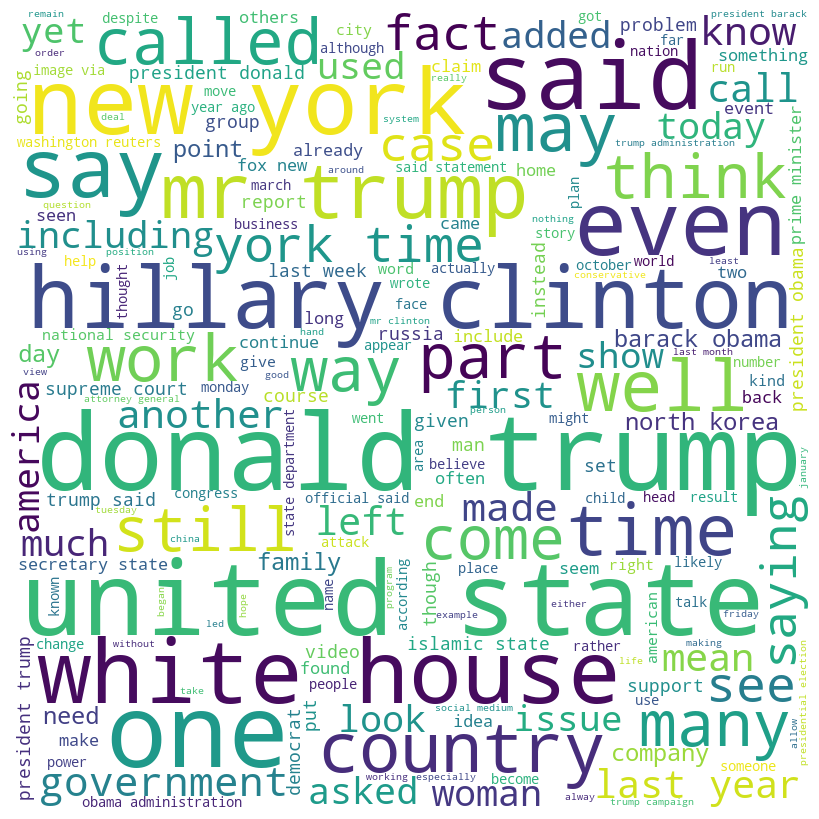

In [21]:
from wordcloud import WordCloud, STOPWORDS
from textwrap import wrap

stopwords = set(STOPWORDS)

news = ' '.join(clean_train_df['news'])

wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=stopwords,
                      min_font_size=10).generate(news)


# plot the wordcloud image
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show();

### Word cloud for Real label news only

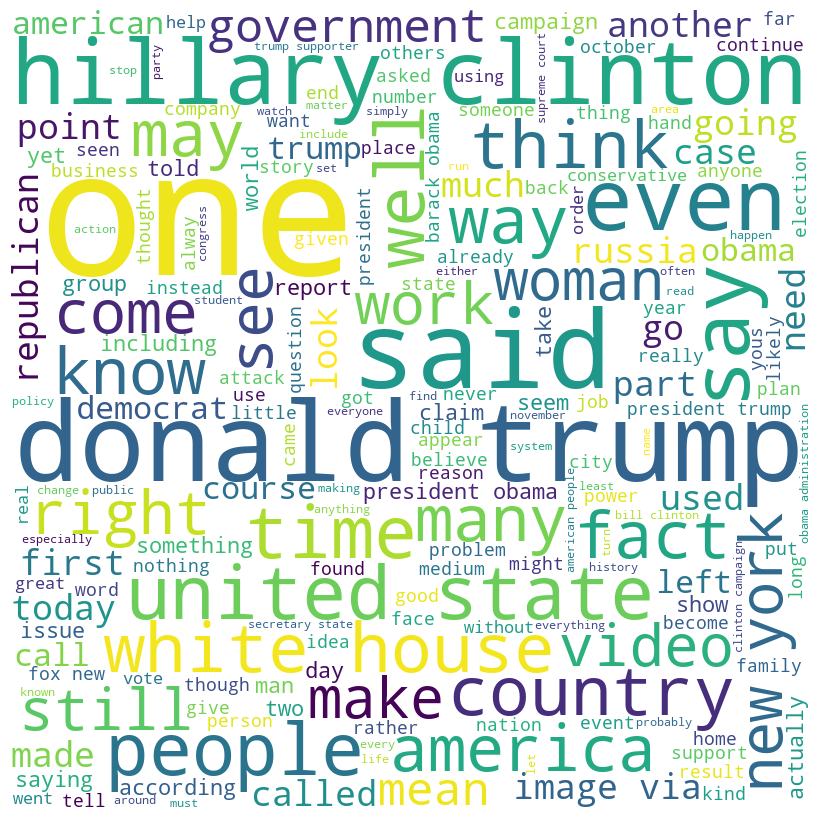

In [28]:
real_news = ' '.join(clean_train_df[clean_train_df.label==1]['news'])

wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=stopwords,
                      min_font_size=10).generate(fake_news)


# plot the wordcloud image
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show();

### Word cloud for Fake label news only

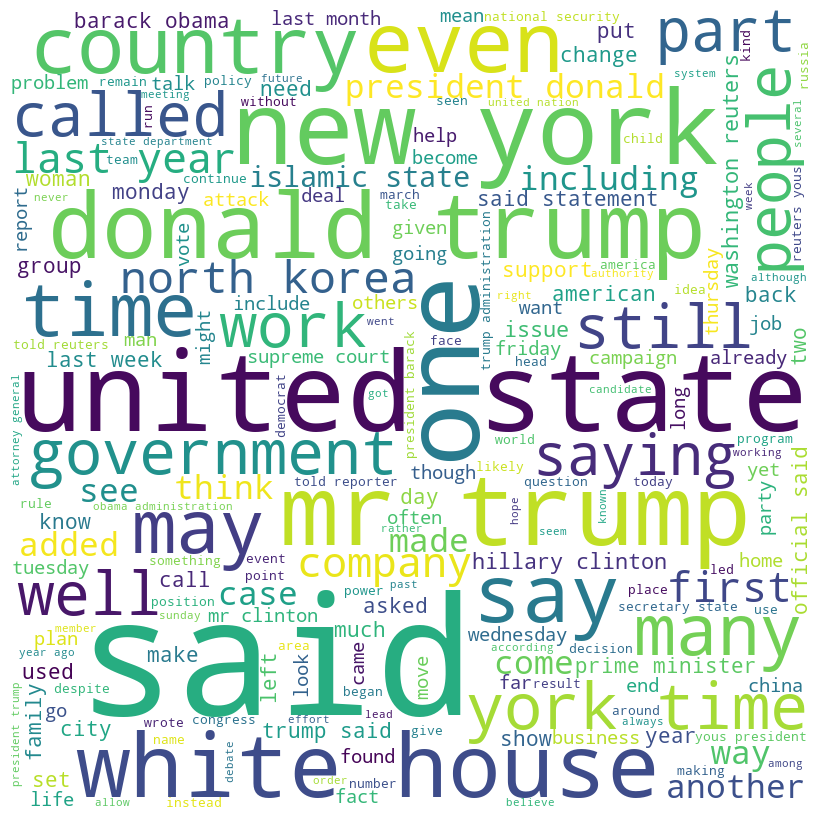

In [29]:
fake_news = ' '.join(clean_train_df[clean_train_df.label==0]['news'])

wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=stopwords,
                      min_font_size=10).generate(not_fake_news)


# plot the wordcloud image
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show();

### Most frequent Bigram(Two word combination) of True label

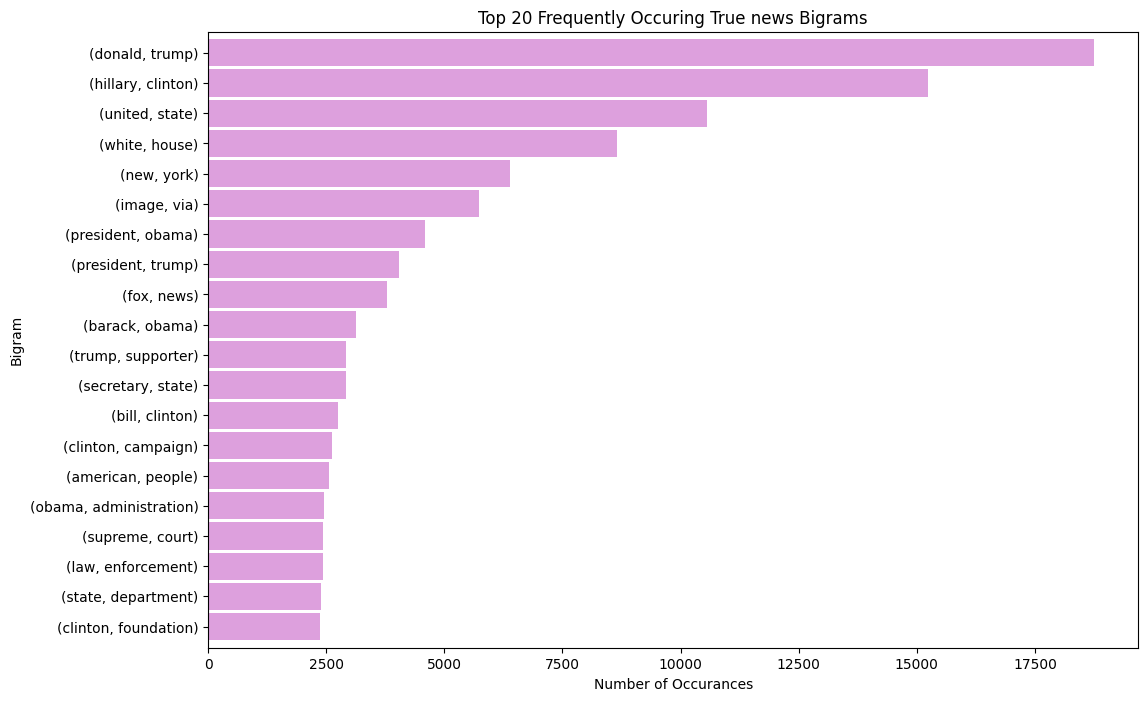

In [30]:
true_bigrams = pd.Series(nltk.ngrams(real_news.split(), 2)).value_counts()[:20]

true_bigrams.sort_values().plot.barh(color='plum', width=.9, figsize=(12, 8))
plt.title('Top 20 Frequently Occuring True news Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')
plt.show();

### Most frequent Bigram(Two word combination) of Fake label

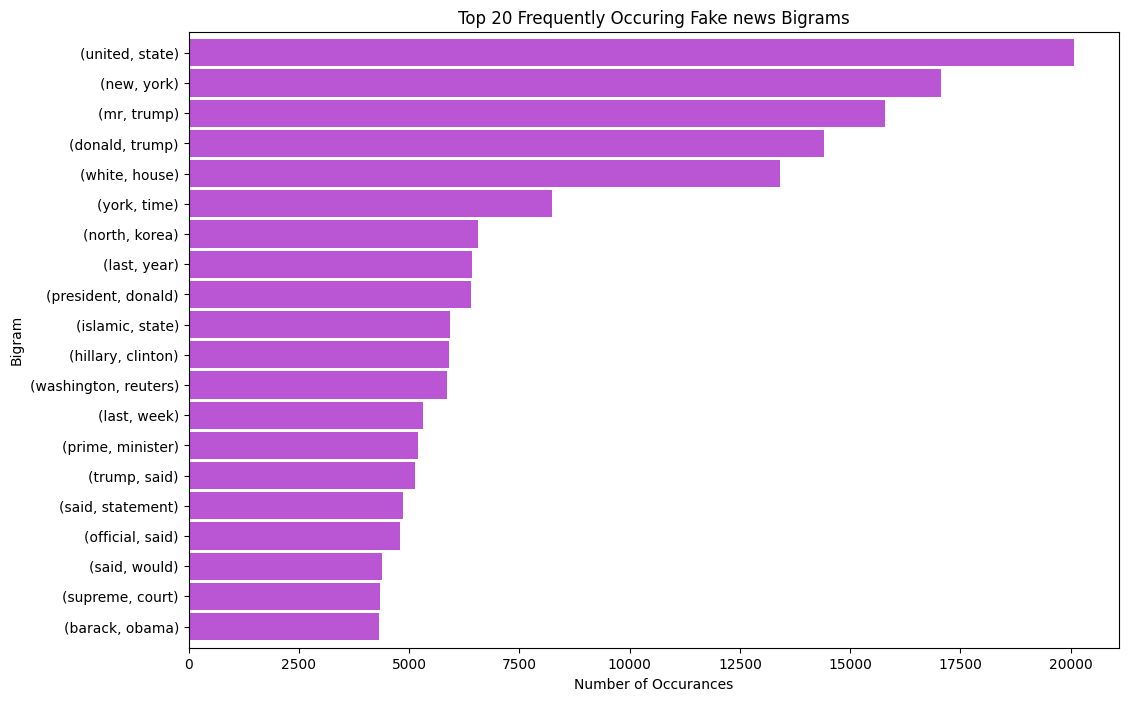

In [32]:
fake_bigrams = pd.Series(nltk.ngrams(fake_news.split(), 2)).value_counts()[:20]

fake_bigrams.sort_values().plot.barh(color='mediumorchid', width=.9, figsize=(12, 8))
plt.title('Top 20 Frequently Occuring Fake news Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')
plt.show();

### Most frequent Trigram(Three word combination) of True label

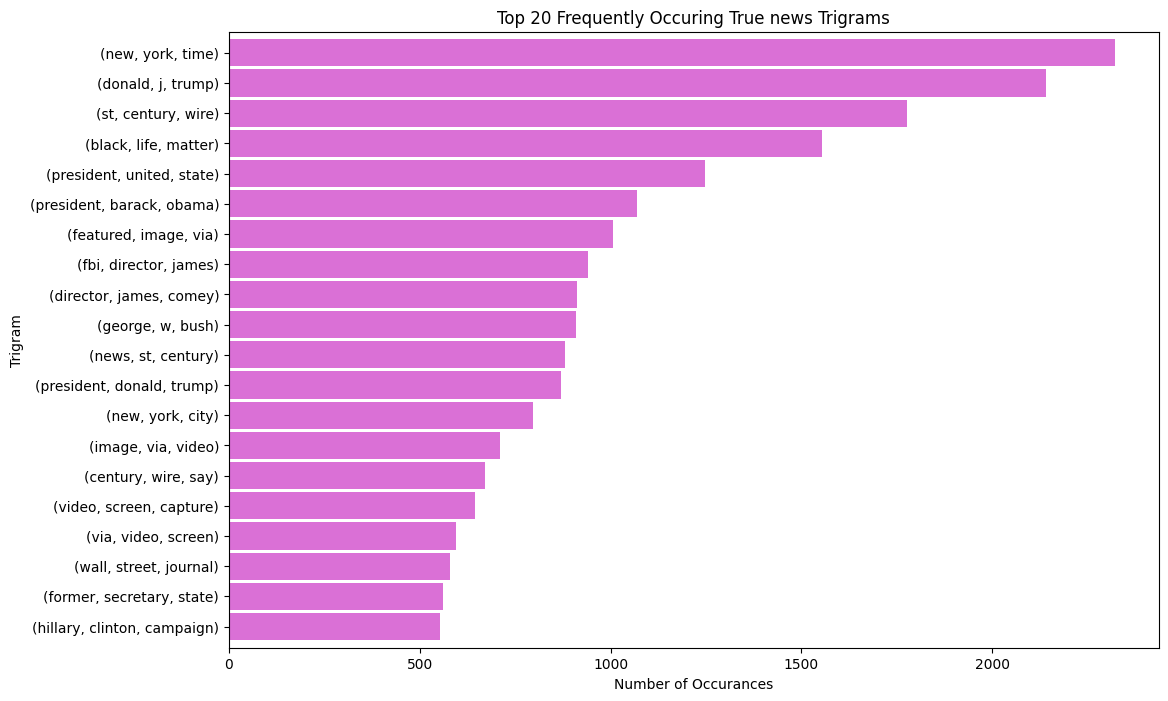

In [33]:
true_trigrams = pd.Series(nltk.ngrams(real_news.split(), 3)).value_counts()[:20]

true_trigrams.sort_values().plot.barh(color='orchid', width=.9, figsize=(12, 8))
plt.title('Top 20 Frequently Occuring True news Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Number of Occurances')
plt.show();

### Most frequent Trigram(Three word combination) of Fake label

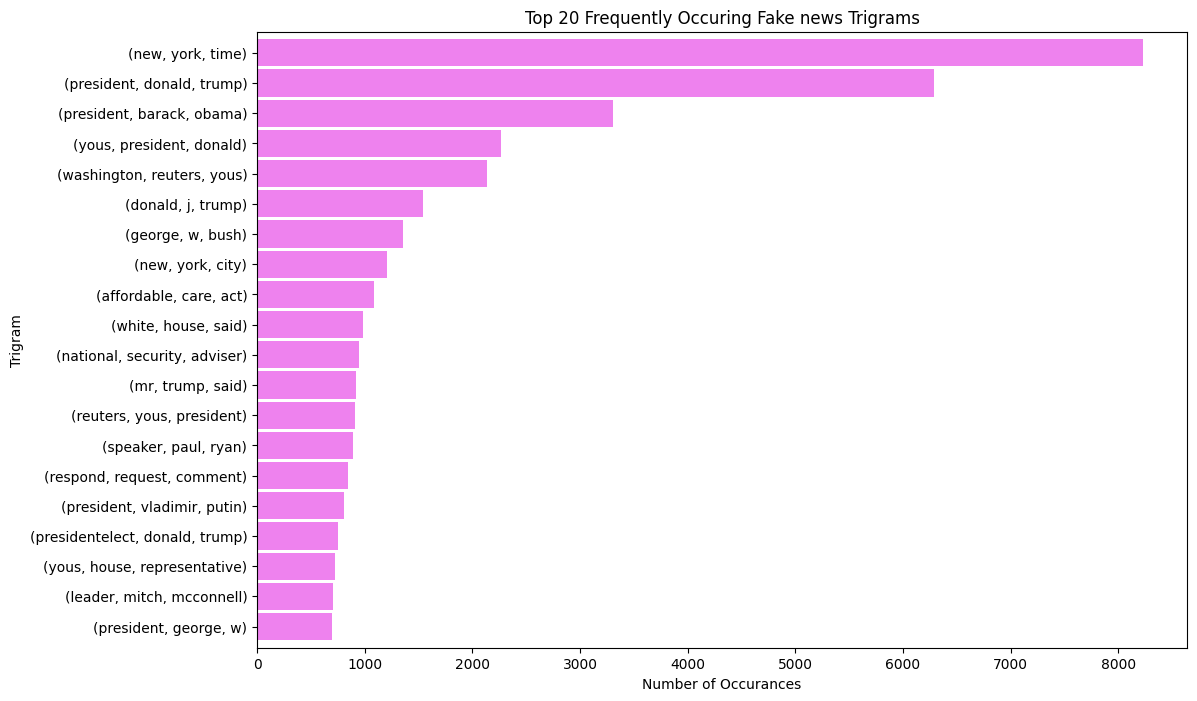

In [34]:
fake_trigrams = pd.Series(nltk.ngrams(fake_news.split(), 3)).value_counts()[:20]

fake_trigrams.sort_values().plot.barh(color='violet', width=.9, figsize=(12, 8))
plt.title('Top 20 Frequently Occuring Fake news Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Number of Occurances')
plt.show();

## Data Preparation

- Seperate training text and labels
- Tokenization
- Text sequence generation
- Pad the text sequence data

In [37]:
X_train, y_train = train_df.news, train_df.label
X_test, y_test = test_df.news, test_df.label

X_train.shape, y_train.shape

((64386,), (64386,))

In [38]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Tokenization

In [39]:
vocab_size = 100000+1

tokenizer = Tokenizer(num_words=vocab_size-1, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)

In [40]:
len(tokenizer.word_index)

258253

In [41]:
import itertools

word_count = tokenizer.word_counts # count of all words in corpus
dict(itertools.islice(dict(word_count).items(), 10))

{'syrian': 8846,
 'kurdish': 2654,
 'ypg': 360,
 'accuses': 508,
 'turkey': 5789,
 'afrin': 34,
 'aggression': 949,
 'beirut': 643,
 'reuters': 26615,
 'militia': 1814}

In [42]:
n_vocab = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {n_vocab}")

print("\nWords at the top")
print(dict(list(tokenizer.word_index.items())[:10]))
print("\nWords at the bottom")
print(dict(list(tokenizer.word_index.items())[-10:]))

Vocabulary size: 258254

Words at the top
{'<OOV>': 1, 'said': 2, 'trump': 3, 'state': 4, 'would': 5, 'people': 6, 'one': 7, 'president': 8, 'new': 9, 'mr': 10}

Words at the bottom
{'republicani': 258244, 'latefor': 258245, 'stuffstill': 258246, 'legacyval': 258247, 'partyjust': 258248, 'coverupsgenerally': 258249, 'chinai': 258250, 'prosecutionif': 258251, 'nsaaffiliated': 258252, 'nsalinked': 258253}


In [43]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)

len(X_train_sequences), len(X_train_sequences[0]), len(X_train_sequences[1])

(64386, 145, 522)

In [48]:
X_test_sequences = tokenizer.texts_to_sequences(X_test)

len(X_test_sequences), len(X_test_sequences[0]), len(X_test_sequences[1])

(7154, 259, 59)

### Padding

Here we analyze the `1%` and `99%` percentiles of the sequence lengths. We should use the 99% percentile as our maximum sequence length.

But since we are using glove word embeddings, let's keep `max_seq_len=300` as we w'll using glove pretrained word embedding: `glove.6B.300d.txt`

In [44]:
clean_train_df['news'].str.split(" ").str.len().describe(percentiles=[0.01, 0.5, 0.99])

count    64386.000000
mean       308.144581
std        335.989242
min          1.000000
1%          10.000000
50%        231.000000
99%       1486.000000
max      11839.000000
Name: news, dtype: float64

In [45]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [49]:
max_seq_len = 300

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_seq_len,
                               padding='post', truncating='post')

X_test_padded = pad_sequences(X_test_sequences, maxlen=max_seq_len,
                               padding='post', truncating='post')

In [50]:
X_train_padded.shape, X_test_padded.shape

((64386, 300), (7154, 300))

### Embeddings

In [53]:
url = 'https://nlp.stanford.edu/data/glove.6B.zip'


def download_glove(url, data_dir):
    """Download a file if not present, and make sure it's the right size."""
    
    os.makedirs(data_dir, exist_ok=True)

    file_path = os.path.join(data_dir, os.path.basename(url))
  
    if not os.path.exists(file_path):
        print('Downloading file...')
        filename, _ = urlretrieve(url, file_path)
    else:
        print("File already exists")
  
    extract_path = os.path.join(data_dir, 'glove')
    os.makedirs(extract_path, exist_ok=True)
    
    if not any(os.scandir(extract_path)):
        print(f"Extracting {os.path.basename(url)}")
        
        with zipfile.ZipFile(file_path, 'r') as zipf:
            zipf.extractall(extract_path)
            
        print(f"File extracted to [../input/glove]")
    else:
        print(f"{os.path.basename(url)} has already been extracted")
    

download_dir = ROOT_DIR/"input"    
download_glove(url, download_dir)

File already exists
glove.6B.zip has already been extracted


In [54]:
embedding_dim = max_seq_len # 300
file_path = ROOT_DIR/f"input/glove/glove.6B.{str(embedding_dim)}d.txt"

word_vec = pd.read_table(file_path, sep=r"\s", header=None, engine='python',
                         encoding='iso-8859-1', on_bad_lines='skip')

word_vec = word_vec.set_index(0)

word_vec.head()

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
the,0.046560,0.213180,-0.007436,-0.458540,-0.035639,0.236430,-0.288360,0.215210,-0.134860,-1.6413,...,-0.013064,-0.296860,-0.079913,0.195000,0.031549,0.285060,-0.087461,0.009061,-0.209890,0.053913
",",-0.255390,-0.257230,0.131690,-0.042688,0.218170,-0.022702,-0.178540,0.107560,0.058936,-1.3854,...,0.075968,-0.014359,-0.073794,0.221760,0.146520,0.566860,0.053307,-0.232900,-0.122260,0.354990
.,-0.125590,0.013630,0.103060,-0.101230,0.098128,0.136270,-0.107210,0.236970,0.328700,-1.6785,...,0.060148,-0.156190,-0.119490,0.234450,0.081367,0.246180,-0.152420,-0.342240,-0.022394,0.136840
of,-0.076947,-0.021211,0.212710,-0.722320,-0.139880,-0.122340,-0.175210,0.121370,-0.070866,-1.5721,...,-0.366730,-0.386030,0.302900,0.015747,0.340360,0.478410,0.068617,0.183510,-0.291830,-0.046533
to,-0.257560,-0.057132,-0.671900,-0.380820,-0.364210,-0.082155,-0.010955,-0.082047,0.460560,-1.8477,...,-0.012806,-0.597070,0.317340,-0.252670,0.543840,0.063007,-0.049795,-0.160430,0.046744,-0.070621


In [55]:
embeddings_index = word_vec.T.to_dict(orient='list')

In [56]:
word_index = tokenizer.word_index

In [57]:
embedding_matrix = np.zeros((len(word_index) + 1, max_seq_len))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = np.asarray(embedding_vector)

In [58]:
embedding_matrix.shape

(258254, 300)

## LSTM Model

In [59]:
from tensorflow.keras.backend import clear_session

clear_session()

In [60]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=max_seq_len,
                            weights=[embedding_matrix],
                            input_length=max_seq_len,
                            trainable=False)

In [61]:
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(embedding_layer)
model.add(LSTM(max_seq_len))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          77476200  
                                                                 
 lstm (LSTM)                 (None, 300)               721200    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 32)                9632      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 78,207,065
Trainable params: 730,865
Non-t

In [63]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [64]:
history = model.fit(X_train_padded, y_train, 
                    epochs=30, batch_size=256,
                    validation_data=(X_test_padded, y_test),
                     workers=10)

Epoch 1/30
252/252 [==============================] - 26s 65ms/step - loss: 0.6359 - accuracy: 0.6482 - val_loss: 0.5938 - val_accuracy: 0.7411
Epoch 2/30
252/252 [==============================] - 16s 64ms/step - loss: 0.5445 - accuracy: 0.7335 - val_loss: 0.3401 - val_accuracy: 0.8650
Epoch 3/30
252/252 [==============================] - 17s 66ms/step - loss: 0.2516 - accuracy: 0.9099 - val_loss: 0.1541 - val_accuracy: 0.9448
Epoch 4/30
252/252 [==============================] - 16s 65ms/step - loss: 0.1586 - accuracy: 0.9442 - val_loss: 0.1369 - val_accuracy: 0.9484
Epoch 5/30
252/252 [==============================] - 16s 65ms/step - loss: 0.1283 - accuracy: 0.9547 - val_loss: 0.1205 - val_accuracy: 0.9579
Epoch 6/30
252/252 [==============================] - 16s 65ms/step - loss: 0.1114 - accuracy: 0.9598 - val_loss: 0.1074 - val_accuracy: 0.9604
Epoch 7/30
252/252 [==============================] - 17s 66ms/step - loss: 0.0913 - accuracy: 0.9671 - val_loss: 0.0932 - val_accuracy:

In [66]:
model.evaluate(X_test_padded, y_test)

224/224 [==============================] - 3s 15ms/step - loss: 0.1543 - accuracy: 0.9751


[0.15433430671691895, 0.9751188158988953]

In [78]:
model.save('../output/lstm_model.h5')

In [68]:
y_pred = model.predict(X_test_padded)
y_pred = np.round(y_pred.reshape((len(y_pred))))
y_pred

224/224 [==============================] - 3s 15ms/step


array([1., 0., 1., ..., 0., 0., 0.], dtype=float32)

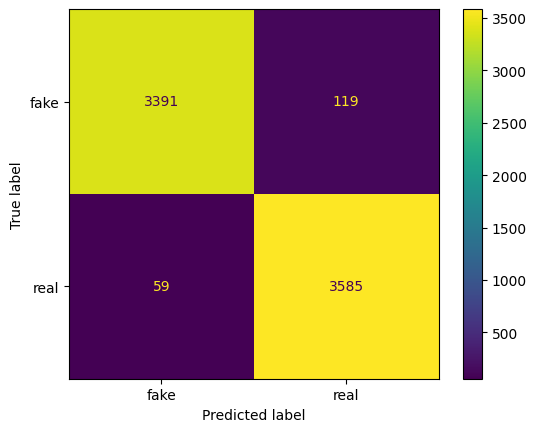

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['fake','real'])
disp.plot()
plt.show()